<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/08_contextual_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Contextual Word Embeddings

Word embeddings are the best invention! That would indeed be the case if only actual languages were straightforward and
organized—unfortunately, they are nothing like that.

Let me show you two sentences from Alice’s Adventures in Wonderland:

* The Hatter was the first to break the silence. `What day of the month is it' he said, turning to Alice: he had taken his **watch** out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.
* Alice thought this a very curious thing, and she went nearer to **watch** them, and just as she came up to them she heard one of them say, `Look out now, Five! Don’t go splashing paint over me like that!

In the first sentence, the word "watch" is a noun and it refers to the object the Hatter had taken out of his pocket. In the second sentence, "watch" is a verb and it refers to what Alice is doing.

Clearly, two very different meanings for the same word.

But, if we look the "watch" token up in our vocabulary, we’ll always retrieve the same values from the word embeddings, regardless of the actual meaning of the word in a sentence.

Can we do better? Of course!

Instead of taking a word by itself, we can take its context too in order to compute the vector that best represents a word. That was the whole point of word embeddings: finding numerical representation for words (or tokens).

That’s great, but it seems impractical.

Trying to build a lookup table for every possible
combination of word and context is probably not such a great idea—that’s why
contextual word embeddings won’t come from a lookup table but from the
outputs of a model instead.



We’ll start our NLP journey by following the steps of Alice and Dorothy, from
[Alice’s Adventures in Wonderland](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1476) by Lewis Carroll and [The Wonderful Wizard of Oz](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1740) by L. Frank Baum.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/alice_dorothy.png?raw=1)

*Left: "Alice and the Baby Pig" illustration by John Tenniel's, from "Alice's Adventure's in Wonderland" (1865).*

*Right: "Dorothy meets the Cowardly Lion" illustration by W.W. Denslow, from "The Wonderful Wizard of Oz" (1900)*


##Setup

In [1]:
%%capture

# # UPDATED
# ###########################################################
!pip install gensim==4.3.1
# # The library has been archived and won't be used anymore
# # # !pip install allennlp==0.9.0
!pip install flair==0.12.2
#!pip install torchvision==0.15.1
# # # HuggingFace
!pip install transformers==4.32.0
!pip install datasets==2.14.4
# ###########################################################
!pip -q install spacy
!python -m spacy download en_core_web_sm

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

Finished!


In [3]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 10
from seq2seq import *

import spacy
import nltk
from nltk.tokenize import sent_tokenize

from flair.data import Sentence
from flair.embeddings import FlairEmbeddings
from flair.embeddings import WordEmbeddings
from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import TransformerDocumentEmbeddings

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [6]:
from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

##Downloading Books

In [7]:
!rm -rf data

In [8]:
# let's download data
HOME_DIR = "data"
download_text(ALICE_URL, HOME_DIR)
download_text(WIZARD_URL, HOME_DIR)

In [9]:
# let's see the downloaded data
#!cat data/alice28-1476.txt

In [10]:
#!cat data/wizoz10-1740.txt

We need to remove these additions to the original texts:

In [11]:
alice_file = os.path.join(HOME_DIR, "alice28-1476.txt")
with open(alice_file, "r") as f:
  # The actual texts of the books are contained between lines 105 and 3703
  alice_text = "".join(f.readlines()[104:3704])

wizard_file = os.path.join(HOME_DIR, "wizoz10-1740.txt")
with open(wizard_file, "r") as f:
  # The actual texts of the books are contained between lines 309 and 5099
  wizard_text = "".join(f.readlines()[310:5100])

In [12]:
print(alice_text[:500])
print("\n", "#"*70, "\n")
print(wizard_text[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w

 ###################################################################### 

                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking

We can partially automate the removal of the extra lines by setting the real start and end lines of each text in a configuration file.

In [13]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(HOME_DIR, 'lines.cfg'), 'w').write(text_cfg)

##Sentence Tokenization

A token is a piece of a text, and to tokenize a text means to split
it into pieces; that is, into a list of tokens.

The most common kind of piece is a word.

So, tokenizing a text usually means to
split it into words using the white space as a separator.

In [14]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(" ")
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

Let's do sentence tokenization, which means to split a text into its sentences.

In [15]:
corpus_alice = sent_tokenize(alice_text)
corpus_wizard = sent_tokenize(wizard_text)

len(corpus_alice), (len(corpus_wizard))

(1612, 2240)

Let’s check one sentence from the first corpus of text.

In [16]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

Let’s check one sentence from the second corpus of text.

In [17]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

Our dataset is going to be a collection of CSV files, one file for each book, with each
CSV file containing one sentence per line.

Therefore, we need to:

* clean the line breaks to make sure each sentence is on one line only;
* define an appropriate quote char to "wrap" the sentence such that the original commas and semicolons in the original text do not get misinterpreted as separation chars of the CSV file; and
* add a second column to the CSV file to
identify the original source of the sentence since we’ll be concatenating, and
shuffling the sentences before training a model on our corpora.

The sentence above should end up looking like this:
```log
\"There's a cyclone coming, Em," he called to his wife.\,wizoz10-1740.txt
```

The function below does the grunt work of cleaning, splitting, and saving the
sentences to a CSV file for us:

In [18]:
def sentence_tokenize(source, quote_char="\\", sep_char=",", include_header=True, include_source=True, extensions=("txt"), **kwargs):
  # If source is a folder, goes through all files inside it that match the desired extensions ('txt' by default)
  if os.path.isdir(source):
    filenames = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f)) and os.path.splitext(f)[1][1:] in extensions]
  elif isinstance(source, str):
    filenames = [source]

  # If there is a configuration file, builds a dictionary with the corresponding start and end lines of each text file
  config_file = os.path.join(source, "lines.cfg")
  config = {}
  if os.path.exists(config_file):
    with open(config_file, "r") as f:
      rows = f.readlines()
    for r in rows[1:]:
      fname, start, end = r.strip().split(",")
      config.update({fname: (int(start), int(end))})

  new_fnames = []
  # For each file of text
  for fname in filenames:
    # If there's a start and end line for that file, use it
    try:
        start, end = config[fname]
    except KeyError:
        start = None
        end = None

    # Opens the file, slices the configures lines (if any)
    # cleans line breaks and uses the sentence tokenizer
    with open(os.path.join(source, fname), 'r') as f:
        contents = (''.join(f.readlines()[slice(start, end, None)]).replace('\n', ' ').replace('\r', ''))
    corpus = sent_tokenize(contents, **kwargs)

    # Builds a CSV file containing tokenized sentences
    base = os.path.splitext(fname)[0]
    new_fname = f'{base}.sent.csv'
    new_fname = os.path.join(source, new_fname)
    with open(new_fname, 'w') as f:
        # Header of the file
        if include_header:
            if include_source:
                f.write('sentence,source\n')
            else:
                f.write('sentence\n')
        # Writes one line for each sentence
        for sentence in corpus:
            if include_source:
                f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
            else:
                f.write(f'{quote_char}{sentence}{quote_char}\n')
    new_fnames.append(new_fname)

  # Returns list of the newly generated CSV files
  return sorted(new_fnames)

In [19]:
new_fnames = sentence_tokenize(HOME_DIR)
new_fnames

['data/alice28-1476.sent.csv', 'data/wizoz10-1740.sent.csv']

##Spacy sentence tokenization

In [20]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

sentences = []
for doc in nlp.pipe(corpus_alice):
  sentences.extend(sent.text for sent in doc.sents)

len(sentences), sentences[2]

(1615,
 'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!')

##HuggingFace’s Dataset

In [ ]:
# let's load from local files using HuggingFace
dataset = load_dataset(path="csv", data_files=new_fnames, quotechar="\\", split=Split.TRAIN)

In [22]:
# let's see attributes, like features, num_columns, and shape
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

In [23]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [24]:
dataset["sentence"][:3]

["                ALICE'S ADVENTURES IN WONDERLAND                            Lewis Carroll                 THE MILLENNIUM FULCRUM EDITION 2.8                                 CHAPTER I                        Down the Rabbit-Hole     Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice `without pictures or conversation?'",
 'So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.',
 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!']

In [25]:
dataset["source"][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

In [26]:
# check the unique sources
dataset.unique("source")

['alice28-1476.txt', 'wizoz10-1740.txt']

In [27]:
# let's create new columns
def is_alice_label(row):
  is_alice = int(row["source"] == "alice28-1476.txt")
  return {"label": is_alice}

In [ ]:
dataset = dataset.map(is_alice_label)

In [29]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt',
 'label': 1}

In [30]:
# Now, we can finally shuffle the dataset and split it into training and test sets
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'source', 'label'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['sentence', 'source', 'label'],
        num_rows: 771
    })
})

In [31]:
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

In [32]:
train_dataset[0]

{'sentence': 'Here was another puzzling question; and as Alice could not think of any good reason, and as the Caterpillar seemed to be in a VERY unpleasant state of mind, she turned away.',
 'source': 'alice28-1476.txt',
 'label': 1}

##ELMo

ELMo is able to understand that words may have different meanings
in different contexts. If you feed it a sentence, it will give you back embeddings for
each of the words while taking the full context into account.

Let’s use the two sentences containing the word "watch" to illustrate how to use
flair to get contextual word embeddings:

In [37]:
watch1 = """
The Hatter was the first to break the silence. `What day of the month is it?'
he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily,
 shaking it every now and then, and holding it to his ear.
"""

watch2 = """
Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say,
`Look out now, Five!  Don't go splashing paint over me like that!
"""

sentences = [watch1, watch2]

In [38]:
flair_sentences = [Sentence(s) for s in sentences]
flair_sentences[0]

Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily,  shaking it every now and then, and holding it to his ear."

In [39]:
flair_sentences[0].get_token(32)

Token[31]: "watch"

In [40]:
flair_sentences[0].tokens[31]

Token[31]: "watch"

In [ ]:
# load Embeddings
flair_emb = FlairEmbeddings("news-forward")

In [42]:
flair_emb.embed(flair_sentences)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily,  shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [43]:
# Let’s check the embeddings for the word "watch" in both sentences
token_watch1 = flair_sentences[0].tokens[31]
token_watch2 = flair_sentences[1].tokens[13]

token_watch1, token_watch2

(Token[31]: "watch", Token[13]: "watch")

In [44]:
token_watch1.embedding, token_watch2.embedding

(tensor([-0.0007, -0.0057,  0.0187,  ..., -0.0051, -0.0022,  0.0026]),
 tensor([-0.0011, -0.0037,  0.1031,  ..., -0.0079, -0.0044,  0.0002]))

In [45]:
# let's find out its cosine similarity
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(token_watch1.embedding, token_watch2.embedding)

tensor(0.5003)

We can see that the two words are
not so similar after all. Contextual word embeddings for the win :-)

To get word embeddings for all tokens in a sentence, we can simply stack them up:

In [46]:
def get_embeddings(embeddings, sentence):
  sent = Sentence(sentence)
  embeddings.embed(sent)
  return torch.stack([token.embedding for token in sent.tokens]).float()

In [47]:
get_embeddings(flair_emb, watch1)

tensor([[-2.0933e-03,  5.0415e-04,  4.6944e-02,  ..., -4.4014e-04,
         -3.9301e-02,  1.0601e-02],
        [ 3.2224e-04,  1.4939e-03,  2.5947e-02,  ..., -9.2416e-04,
         -1.4211e-02,  3.0942e-03],
        [ 1.7407e-03, -1.8323e-04,  5.3375e-02,  ...,  4.5166e-04,
          5.4484e-02,  9.7125e-03],
        ...,
        [ 2.2250e-03,  2.2138e-04,  4.4385e-02,  ..., -3.9766e-03,
         -7.9449e-04,  2.2444e-02],
        [-2.2455e-03,  9.7196e-04,  3.4624e-02,  ..., -7.1559e-05,
          1.2647e-02,  1.3210e-02],
        [ 1.0997e-03,  8.4726e-05,  1.5534e-01,  ..., -1.5738e-04,
          9.5801e-04,  5.3785e-03]])

In [48]:
get_embeddings(flair_emb, watch2)

tensor([[ 1.2328e-03, -1.6353e-03,  1.0852e-01,  ..., -3.3656e-05,
          6.3374e-03,  1.8162e-01],
        [-3.3229e-04, -9.9625e-04,  5.9311e-02,  ..., -5.4689e-04,
          3.2166e-04,  2.4364e-03],
        [-1.3625e-02,  2.4192e-05,  1.8871e-02,  ...,  6.3698e-04,
          3.1255e-03,  4.0854e-02],
        ...,
        [ 1.3953e-04, -1.4613e-04,  6.0689e-02,  ..., -5.8437e-03,
         -4.5849e-03,  5.3478e-02],
        [-9.9871e-03,  1.0158e-04,  2.1744e-02,  ..., -1.8228e-03,
          1.3294e-03,  1.3623e-02],
        [ 1.2045e-03,  8.6513e-07,  6.7963e-03,  ..., -8.1871e-05,
          2.1393e-03,  8.9121e-03]])

##BERT

The general idea of obtaining contextual word embeddings
using a language model still holds true for BERT.

First, we need to load BERT in flair using `TransformerWordEmbeddings`:

In [49]:
bert_flair = TransformerWordEmbeddings()

In [50]:
embedding1 = get_embeddings(bert_flair, watch1)
embedding2 = get_embeddings(bert_flair, watch2)

In [51]:
bert_watch1 = embedding1[31]
bert_watch1[:5]

tensor([ 0.8576,  0.3589, -0.3782, -0.8356,  1.3528])

In [52]:
bert_watch2 = embedding2[13]
bert_watch2[:5]

tensor([-0.0984,  1.4698,  0.2857, -0.3957,  0.0969])

Then, let’s compare the embeddings for the word "watch" in both sentences once
again:

In [53]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(bert_watch1, bert_watch2)

tensor(0.3504)

##Document Embeddings

We can use pre-trained models to generate embeddings for whole documents.

In [54]:
documents = [Sentence(watch1), Sentence(watch2)]

In [55]:
# let's get the embeddings
bert_doc = TransformerDocumentEmbeddings("bert-base-uncased")
bert_doc.embed(documents)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily,  shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [56]:
documents[0].embedding[:5]

tensor([-0.0642,  0.3536, -0.2496, -0.5391, -0.1992])

Notice that the individual tokens don’t get their own embeddings anymore.

In [57]:
documents[0].tokens[31].embedding

tensor([])

We can leverage this fact to slightly modify the `get_embeddings()` function so it works with both word and document embeddings.

In [58]:
def get_embeddings(embeddings, sentence):
  sent = Sentence(sentence)
  embeddings.embed(sent)
  if len(sent.embedding):
    return sent.embedding.float()
  else:
    return torch.stack([token.embedding for token in sent.tokens]).float()

In [59]:
get_embeddings(bert_doc, watch1)[:10]

tensor([-0.0642,  0.3536, -0.2496, -0.5391, -0.1992, -0.2771,  0.1694,  0.1087,
        -0.4080, -0.1495])

In [60]:
get_embeddings(bert_doc, watch2)[:10]

tensor([ 0.2446,  0.3837, -0.0012, -0.4806, -0.3587, -0.2017,  0.5984,  0.4345,
        -0.5844, -0.3548])

We can revisit the Sequential model from the "Word Embeddings" section and
modify it to use contextual word embeddings instead.

But, first, we need to change the datasets a bit as well.

##Model III — Preprocessed Embeddings

In [ ]:
#Data Preparation
train_dataset_doc = train_dataset.map(lambda row: {"embeddings": get_embeddings(bert_doc, row["sentence"])})
test_dataset_doc = test_dataset.map(lambda row: {"embeddings": get_embeddings(bert_doc, row["sentence"])})

In [65]:
train_dataset_doc

Dataset({
    features: ['sentence', 'source', 'label', 'embeddings'],
    num_rows: 3081
})

In [66]:
train_dataset_doc.set_format(type="torch", columns=["embeddings", "label"])
test_dataset_doc.set_format(type="torch", columns=["embeddings", "label"])

In [67]:
# get the embeddings for all sentences
train_dataset_doc["embeddings"]

tensor([[-0.1549, -0.2271, -0.2915,  ...,  0.0724,  0.1422,  0.9624],
        [-0.1211,  0.0515, -0.5660,  ...,  0.4919,  0.5666,  0.4847],
        [ 0.0038,  0.2332, -0.3663,  ...,  0.0892,  0.2949,  0.5993],
        ...,
        [-0.3019,  0.1792, -0.4882,  ..., -0.0218,  0.7277,  0.5098],
        [ 0.0019,  0.1225, -0.1366,  ...,  0.2522,  0.3442,  0.4652],
        [ 0.2677,  0.5303,  0.1059,  ..., -0.0570,  0.5660,  0.5486]])

In [68]:
generator = torch.Generator()

train_dataset_doc = TensorDataset(train_dataset_doc["embeddings"].float(), train_dataset_doc["label"].view(-1, 1).float())
train_loader = DataLoader(train_dataset_doc, batch_size=32, shuffle=True, generator=generator)

test_dataset_doc = TensorDataset(test_dataset_doc["embeddings"].float(), test_dataset_doc["label"].view(-1, 1).float())
test_loader = DataLoader(test_dataset_doc, batch_size=32, shuffle=True)

In [69]:
# Model Configuration
torch.manual_seed(41)

# Classifier
model = nn.Sequential(
    nn.Linear(bert_doc.embedding_length, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [70]:
# Model Training
sbs_doc_emb = StepByStep(model, loss_fn, optimizer)
sbs_doc_emb.set_loaders(train_loader, test_loader)
sbs_doc_emb.train(20)

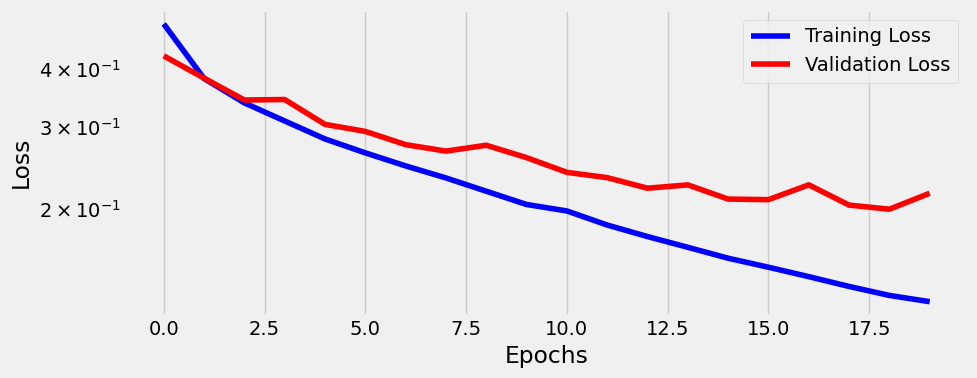

In [71]:
fig = sbs_doc_emb.plot_losses()

In [72]:
StepByStep.loader_apply(test_loader, sbs_doc_emb.correct)

tensor([[417, 436],
        [311, 335]])

That’s 95.20% accuracy on the validation (test) set! Quite impressive for a model with only three hidden units, I might say.

Now, imagine what can be accomplished if we fine-tune the actual BERT model.